In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [130]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
# words[:8]

In [3]:
len(words)

11455

In [15]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
# print(itos)

In [16]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [76]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:2]:
  
  context = [0] * block_size

  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
    # print(X, Y)
  # break
X = torch.tensor(X)
Y = torch.tensor(Y)

In [77]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

In [131]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([71218, 3]) torch.Size([71218])
torch.Size([8952, 3]) torch.Size([8952])
torch.Size([8989, 3]) torch.Size([8989])


In [79]:
C = torch.randn((27, 2))

In [80]:
C[5]

tensor([-0.9155,  0.7762])

In [81]:
C

tensor([[-0.1168,  0.0282],
        [-0.7999, -0.4964],
        [ 0.2800,  0.6120],
        [ 0.7385, -0.2727],
        [-0.0920, -2.0990],
        [-0.9155,  0.7762],
        [-0.1922,  0.0189],
        [-0.0334,  1.0392],
        [-0.6577, -0.4684],
        [-0.4591,  0.3569],
        [ 0.6851,  0.5125],
        [-0.8867, -1.9938],
        [ 2.0487,  0.3970],
        [ 0.9463,  2.2683],
        [ 0.4351,  0.1805],
        [ 0.0227, -0.1003],
        [-0.0412, -0.9395],
        [-0.7879,  0.3374],
        [ 0.4990, -0.4114],
        [ 1.2364, -0.1722],
        [ 1.6510, -0.1101],
        [ 2.1094, -0.1082],
        [-1.1293,  0.5611],
        [-1.1816,  1.6676],
        [-1.9248,  0.7355],
        [ 0.4162, -0.0582],
        [-0.5865, -0.9067]])

In [82]:
X.shape

torch.Size([16, 3])

In [85]:
# C[X]

In [108]:
emb = C[X]
emb.shape

torch.Size([16, 3, 2])

In [109]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [110]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [111]:
h.shape

torch.Size([16, 100])

In [112]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [113]:
logits = h @ W2 + b2

In [114]:
logits.shape

torch.Size([16, 27])

In [116]:
counts = logits.exp()

In [117]:
prob = counts / counts.sum(1, keepdims=True)

In [118]:
prob.shape

torch.Size([16, 27])

In [120]:
prob[0].sum()

tensor(1.0000)

In [121]:
loss = -prob[torch.arange(16), Y].log().mean()
loss

tensor(15.7095)

In [47]:
# ------------ now made respectable :) ---------------

In [132]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([71218, 3]), torch.Size([71218]))

In [133]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [134]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [135]:
for p in parameters:
  p.requires_grad = True

In [136]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [137]:
lri = []
lossi = []
stepi = []

In [138]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

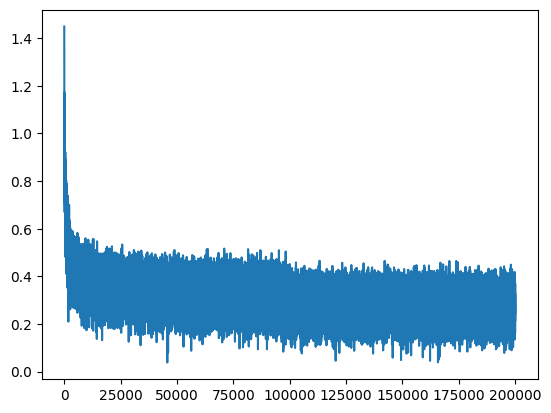

In [139]:
plt.plot(stepi, lossi)

In [140]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9265, grad_fn=<NllLossBackward0>)

In [141]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1131, grad_fn=<NllLossBackward0>)

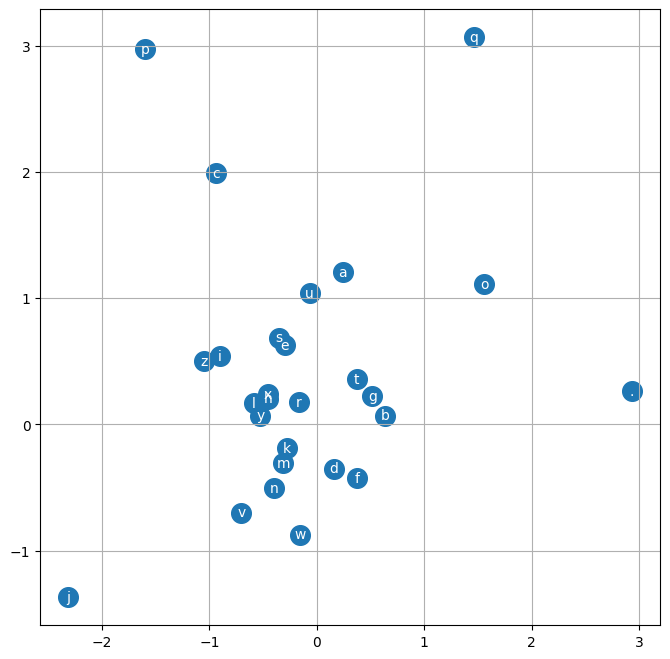

In [142]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [143]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [144]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [145]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpatfally.
leaf.
wrish.
thilds.
cassacreatnender.
sart.
presignesture.
comiit.
priefn.
dism.
pointed.
buts.
lived.
vied.
conterpudeary.
implaughins.
boed.
eail.
bettered.
flouldage.
